In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import logging
from typing import Tuple

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.util import montage

from src.image.filter import FilterVisualizer
from src.utils.logger import get_logger
from src.utils.session import reset_session

2025-01-17 09:22:23.462408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
_ = get_logger(logging.ERROR)

## Load Dataset

In [4]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = tf.keras.datasets.mnist.load_data()

print(f"X_train: {X_train_raw.shape}")
print(f"y_train: {y_train_raw.shape}")
print(f"X_test: {X_test_raw.shape}")
print(f"y_test: {y_test_raw.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


## Preprocess Dataset

In [5]:
X_train = np.expand_dims(X_train_raw, axis=-1) / 255
X_test = np.expand_dims(X_test_raw, axis=-1) / 255
y_train = y_train_raw
y_test = y_test_raw

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (60000, 28, 28, 1)
y_train: (60000,)
X_test: (10000, 28, 28, 1)
y_test: (10000,)


## Build Model

In [6]:
def build_model() -> tf.keras.models.Model:
    inputs = tf.keras.layers.Input(shape=(28, 28, 1), name="input")
    x = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=1, padding="same", name="conv1")(inputs)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="pool1")(x)    
    x = tf.keras.layers.Conv2D(filters=5, kernel_size=(5, 5), strides=1, padding="same", name="conv2")(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="pool2")(x)
    x = tf.keras.layers.Conv2D(filters=20, kernel_size=(5, 5), strides=1, padding="same", name="conv3")(x)
    x = tf.keras.layers.Dropout(0.5, name="dropout1")(x)
    x = tf.keras.layers.Flatten(name="flatten1")(x)
    outputs = tf.keras.layers.Dense(10, activation="softmax", name="output")(x)
    return tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [7]:
reset_session()

In [8]:
model = build_model()

2025-01-17 09:22:25.587944: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 09:22:25.589901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 09:22:25.590012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 09:22:25.590502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 5)         130       
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 5)         0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 5)         630       
                                                                 
 pool2 (MaxPooling2D)        (None, 7, 7, 5)           0         
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 20)          2520      
                                                                 
 dropout1 (Dropout)          (None, 7, 7, 20)          0     

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"]
)

In [11]:
es_cb = tf.keras.callbacks.EarlyStopping(patience=5, mode="min", restore_best_weights=True)
callbacks = [es_cb]

In [12]:
batch_size = 256
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, validation_split=0.2, callbacks=callbacks)

Epoch 1/50


2025-01-17 09:22:26.720813: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-01-17 09:22:27.083031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2025-01-17 09:22:27.731490: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f39304bff30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-17 09:22:27.731514: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2025-01-17 09:22:27.734491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-17 09:22:27.828612: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Com

188/188 [==============================] - 4s 9ms/step - loss: 1.8753 - accuracy: 0.4506 - val_loss: 1.0519 - val_accuracy: 0.7834
Epoch 2/50
188/188 [==============================] - 2s 9ms/step - loss: 0.7845 - accuracy: 0.7722 - val_loss: 0.4902 - val_accuracy: 0.8684
Epoch 3/50
188/188 [==============================] - 2s 10ms/step - loss: 0.5277 - accuracy: 0.8403 - val_loss: 0.3766 - val_accuracy: 0.8951
Epoch 4/50
188/188 [==============================] - 2s 8ms/step - loss: 0.4377 - accuracy: 0.8695 - val_loss: 0.3235 - val_accuracy: 0.9067
Epoch 5/50
188/188 [==============================] - 2s 10ms/step - loss: 0.3836 - accuracy: 0.8830 - val_loss: 0.2890 - val_accuracy: 0.9178
Epoch 6/50
188/188 [==============================] - 2s 10ms/step - loss: 0.3466 - accuracy: 0.8971 - val_loss: 0.2636 - val_accuracy: 0.9243
Epoch 7/50
188/188 [==============================] - 2s 10ms/step - loss: 0.3143 - accuracy: 0.9071 - val_loss: 0.2435 - val_accuracy: 0.9286
Epoch 8/50
18

In [13]:
pred_probs_train = model.predict(X_train, batch_size=batch_size, verbose=0)
pred_probs_test = model.predict(X_test, batch_size=batch_size, verbose=0)

pred_train = np.argmax(pred_probs_train, axis=1)
pred_test = np.argmax(pred_probs_test, axis=1)

acc_train = (pred_train == y_train).sum() / len(y_train)
acc_test = (pred_test == y_test).sum() / len(y_test)

print(f"Accuracy Train (%): {acc_train*100:.2f}")
print(f"Accuracy Test (%): {acc_test*100:.2f}")

Accuracy Train (%): 97.35
Accuracy Test (%): 97.52


## Filter Visualization

### Example: each conv layer ouput

In [14]:
fv = FilterVisualizer(model)

In [15]:
idx = 0

Text(0.5, 1.0, 'True Label: 5')

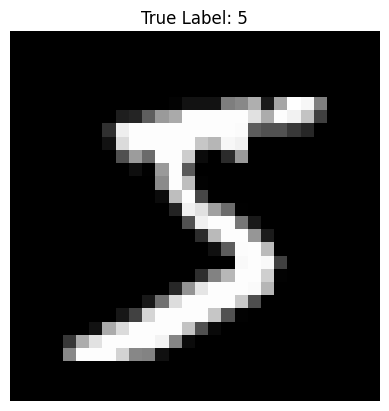

In [16]:
"""
original image
"""

img = X_train[idx]
fig, ax = plt.subplots(1, 1)
ax.imshow(img, cmap="gray")
ax.axis("off")
ax.set_title(f"True Label: {y_train[idx]}")

Label: 5 (Prob: 95.3213%)
Label: 3 (Prob: 4.6767%)
Label: 7 (Prob: 0.0009%)
Label: 2 (Prob: 0.0004%)
Label: 9 (Prob: 0.0004%)


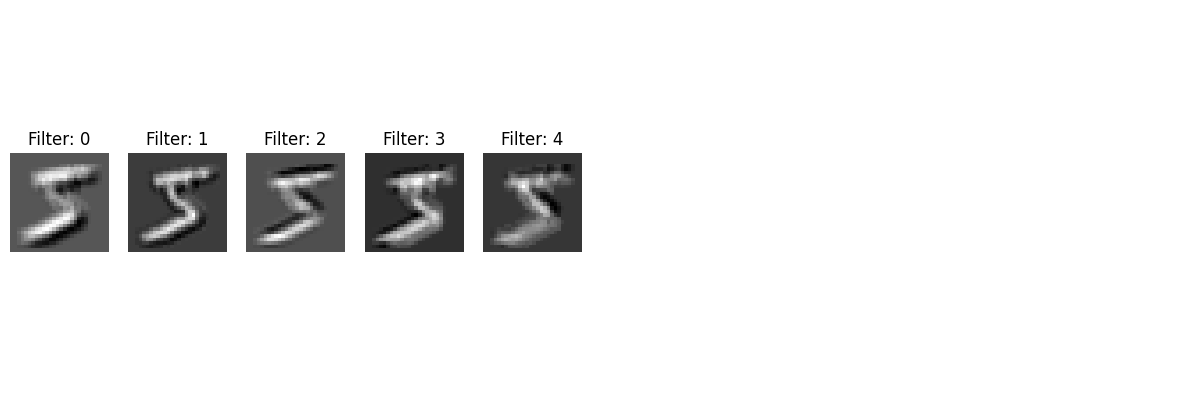

In [17]:
"""
1st conv layer output
- note that there are 5 filters in conv1
- conv1 seems blur the input image and focus on the edges or lines
"""

fv._set_submodel(layer_name="conv1")
fig, axes = fv(img, verbose=True)

Label: 5 (Prob: 95.3213%)
Label: 3 (Prob: 4.6767%)
Label: 7 (Prob: 0.0009%)
Label: 2 (Prob: 0.0004%)
Label: 9 (Prob: 0.0004%)


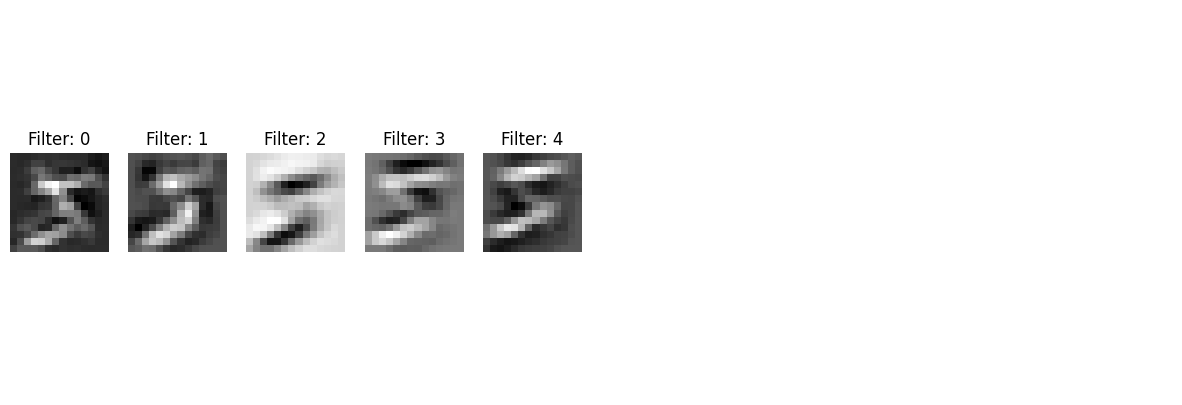

In [18]:
"""
2nd conv layer output
- note that there are 5 filters in conv2
- output conv2 seems more abstract than the output of conv1 and more blurred
"""

fv._set_submodel(layer_name="conv2")
fig, axes = fv(img, verbose=True)

Label: 5 (Prob: 95.3213%)
Label: 3 (Prob: 4.6767%)
Label: 7 (Prob: 0.0009%)
Label: 2 (Prob: 0.0004%)
Label: 9 (Prob: 0.0004%)


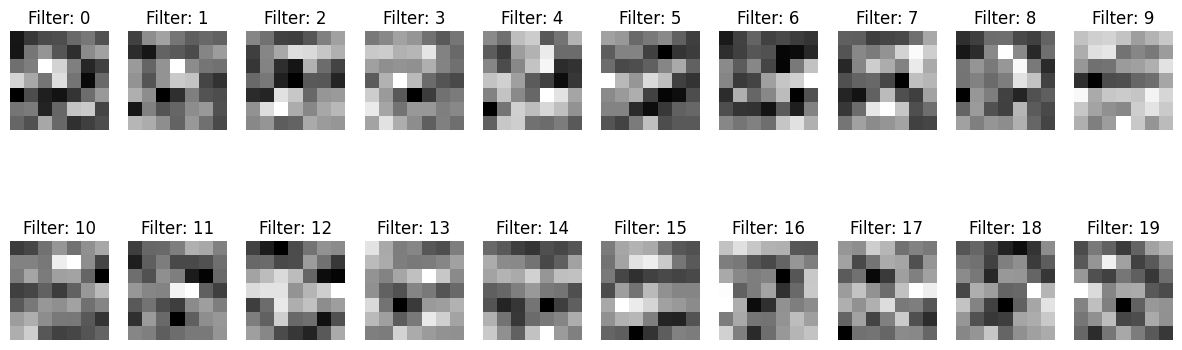

In [19]:
"""
3rd conv layer output
- note that there are 20 filters in conv3
- it's not easy to interprete these outputs
"""

fv._set_submodel(layer_name="conv3")
fig, axes = fv(img, verbose=True)

### Example: inaccurate prediction on test data

In [20]:
false_idxs = [i for i in range(len(pred_test)) if pred_test[i] != y_test[i]]

In [21]:
idx = false_idxs[0]

Text(0.5, 1.0, 'True Label: 9 (Pred Label: 8)')

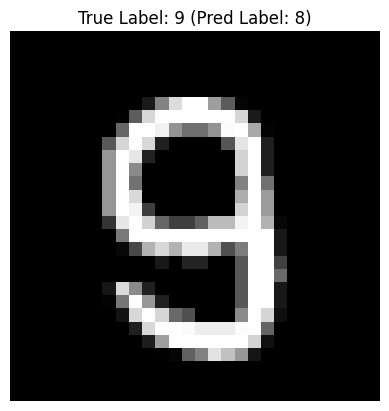

In [22]:
img = X_test[idx]
pred_label = pred_test[idx]
false_idx = np.argmax(y_test == pred_label)
false_img = X_test[false_idx]

fig, ax = plt.subplots(1, 1)
ax.imshow(img, cmap="gray")
ax.axis("off")
ax.set_title(f"True Label: {y_test[idx]} (Pred Label: {pred_label})")

Label: 8 (Prob: 61.3421%)
Label: 9 (Prob: 21.4536%)
Label: 5 (Prob: 10.5846%)
Label: 3 (Prob: 6.0929%)
Label: 2 (Prob: 0.5147%)


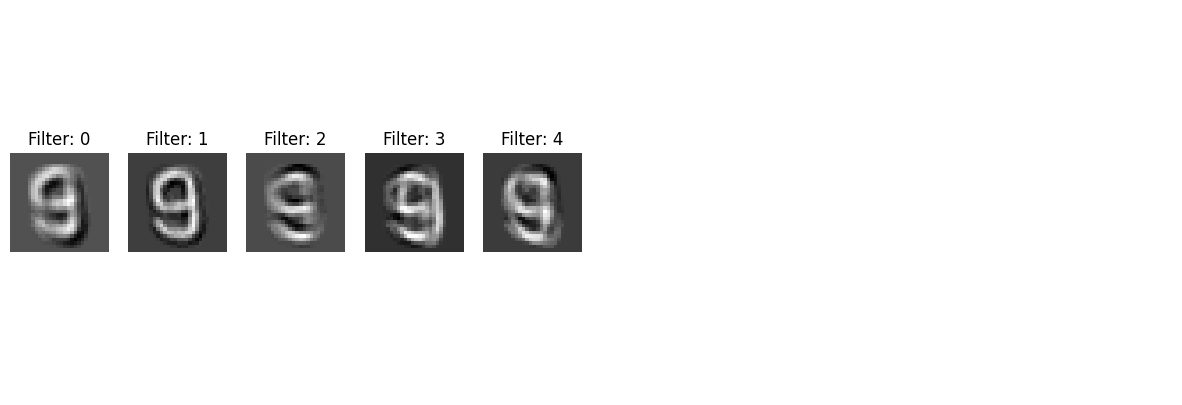

In [23]:
fv._set_submodel(layer_name="conv1")
fig, axes = fv(img, verbose=True)

Label: 8 (Prob: 98.5018%)
Label: 2 (Prob: 0.9573%)
Label: 5 (Prob: 0.3176%)
Label: 3 (Prob: 0.1481%)
Label: 9 (Prob: 0.0504%)


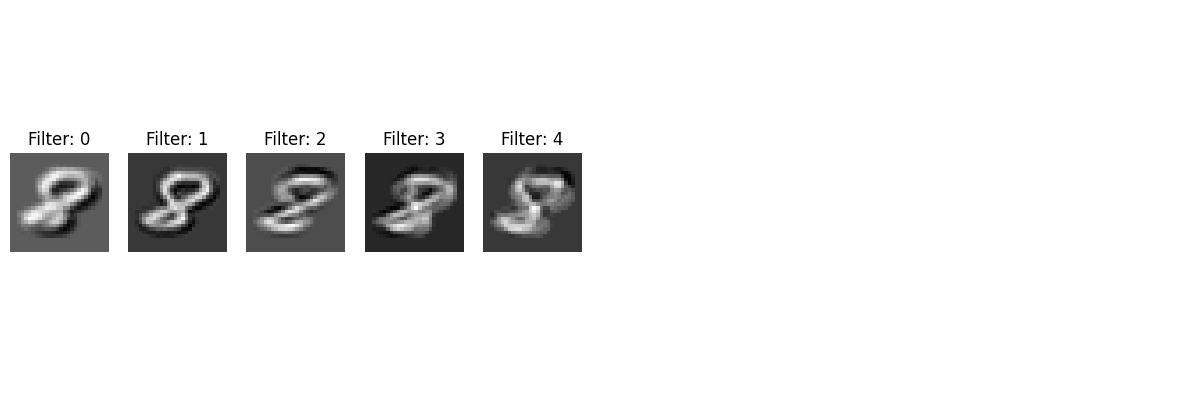

In [24]:
fig, axes = fv(false_img, verbose=True)

Label: 8 (Prob: 61.3421%)
Label: 9 (Prob: 21.4536%)
Label: 5 (Prob: 10.5846%)
Label: 3 (Prob: 6.0929%)
Label: 2 (Prob: 0.5147%)


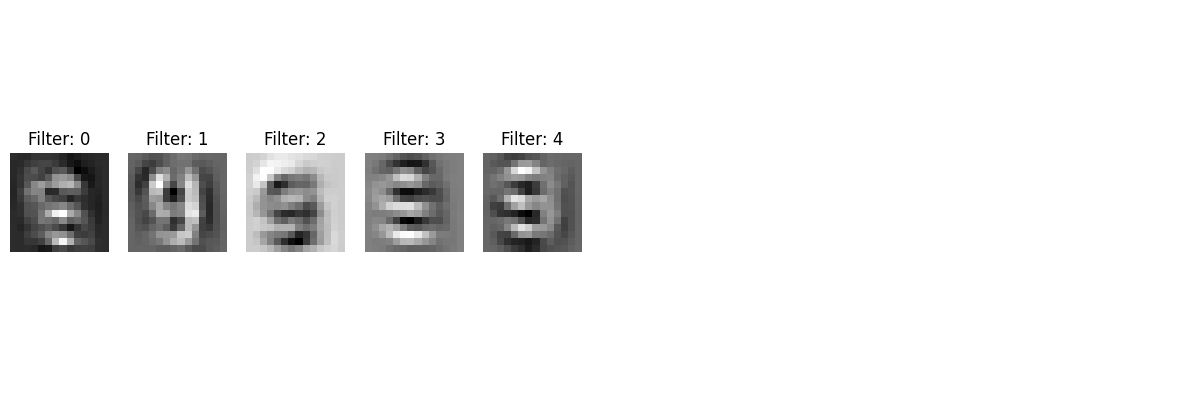

In [25]:
fv._set_submodel(layer_name="conv2")
fig, axes = fv(img, verbose=True)

Label: 8 (Prob: 98.5018%)
Label: 2 (Prob: 0.9573%)
Label: 5 (Prob: 0.3176%)
Label: 3 (Prob: 0.1481%)
Label: 9 (Prob: 0.0504%)


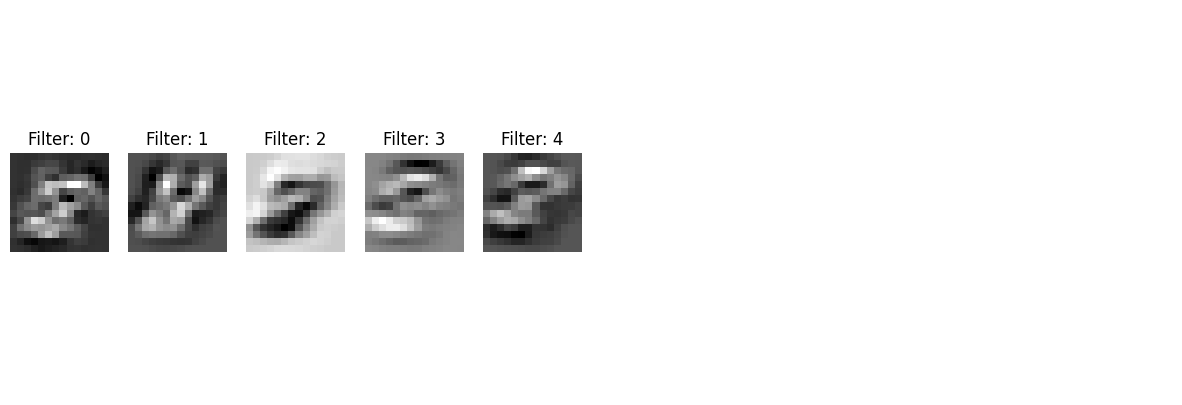

In [26]:
fig, axes = fv(false_img, verbose=True)

In [27]:
idx = false_idxs[3]

Text(0.5, 1.0, 'True Label: 8 (Pred Label: 4)')

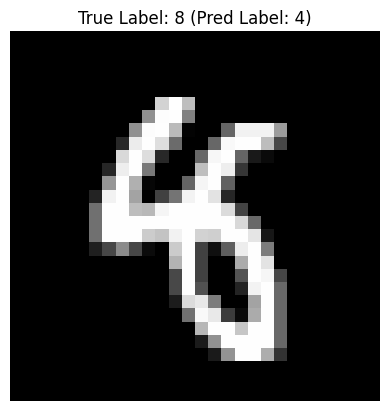

In [28]:
img = X_test[idx]
pred_label = pred_test[idx]
false_idx = np.argmax(y_test == pred_label)
false_img = X_test[false_idx]

fig, ax = plt.subplots(1, 1)
ax.imshow(img, cmap="gray")
ax.axis("off")
ax.set_title(f"True Label: {y_test[idx]} (Pred Label: {pred_label})")

Label: 4 (Prob: 72.8362%)
Label: 8 (Prob: 20.3752%)
Label: 9 (Prob: 4.0437%)
Label: 5 (Prob: 2.6055%)
Label: 6 (Prob: 0.1144%)


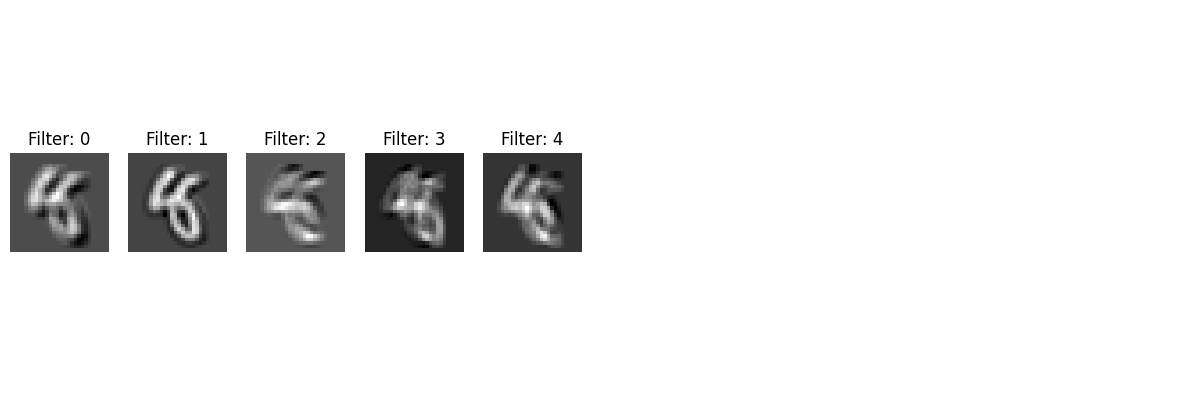

In [29]:
fv._set_submodel(layer_name="conv1")
fig, axes = fv(img, verbose=True)

Label: 4 (Prob: 99.9660%)
Label: 9 (Prob: 0.0335%)
Label: 7 (Prob: 0.0002%)
Label: 6 (Prob: 0.0002%)
Label: 2 (Prob: 0.0000%)


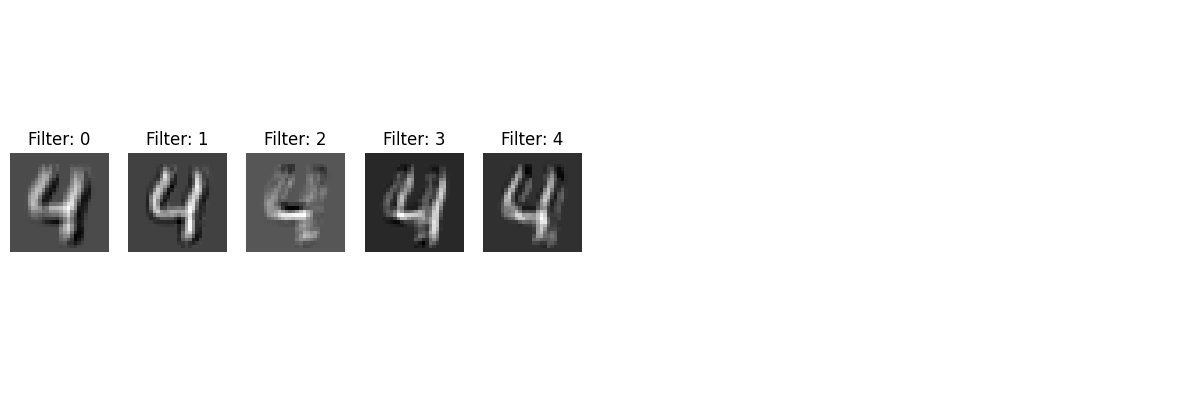

In [30]:
fig, axes = fv(false_img, verbose=True)

Label: 4 (Prob: 72.8362%)
Label: 8 (Prob: 20.3752%)
Label: 9 (Prob: 4.0437%)
Label: 5 (Prob: 2.6055%)
Label: 6 (Prob: 0.1144%)


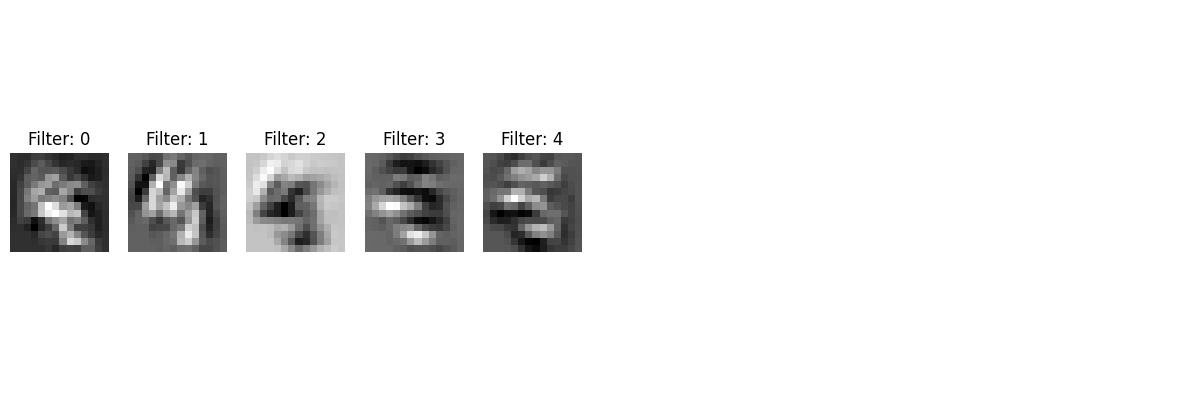

In [31]:
fv._set_submodel(layer_name="conv2")
fig, axes = fv(img, verbose=True)

Label: 4 (Prob: 99.9660%)
Label: 9 (Prob: 0.0335%)
Label: 7 (Prob: 0.0002%)
Label: 6 (Prob: 0.0002%)
Label: 2 (Prob: 0.0000%)


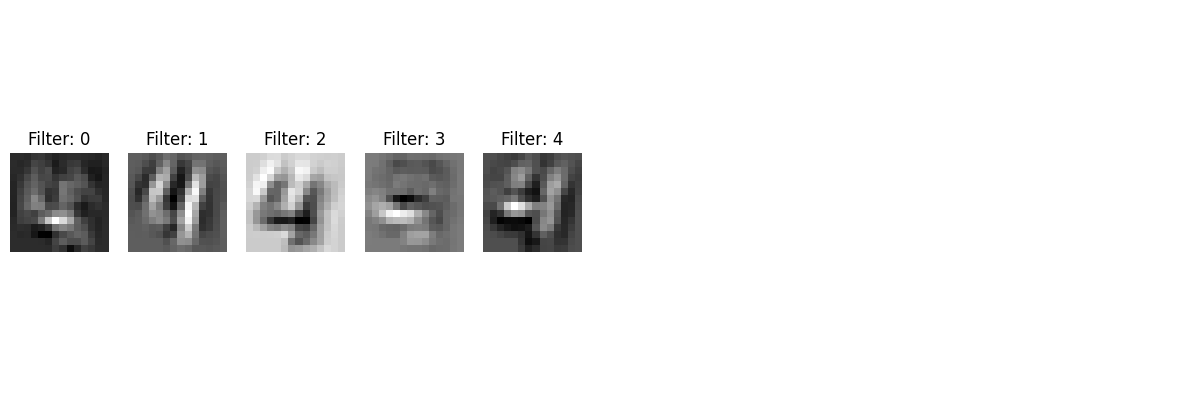

In [32]:
fig, axes = fv(false_img, verbose=True)

In [33]:
idx = false_idxs[15]

Text(0.5, 1.0, 'True Label: 2 (Pred Label: 8)')

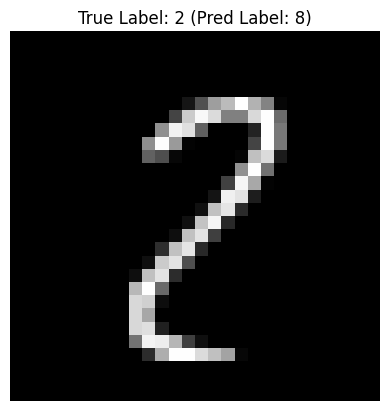

In [34]:
img = X_test[idx]
pred_label = pred_test[idx]
false_idx = np.argmax(y_test == pred_label)
false_img = X_test[false_idx]

fig, ax = plt.subplots(1, 1)
ax.imshow(img, cmap="gray")
ax.axis("off")
ax.set_title(f"True Label: {y_test[idx]} (Pred Label: {pred_label})")

Label: 8 (Prob: 78.6457%)
Label: 2 (Prob: 15.0395%)
Label: 3 (Prob: 5.5634%)
Label: 9 (Prob: 0.3689%)
Label: 0 (Prob: 0.2273%)


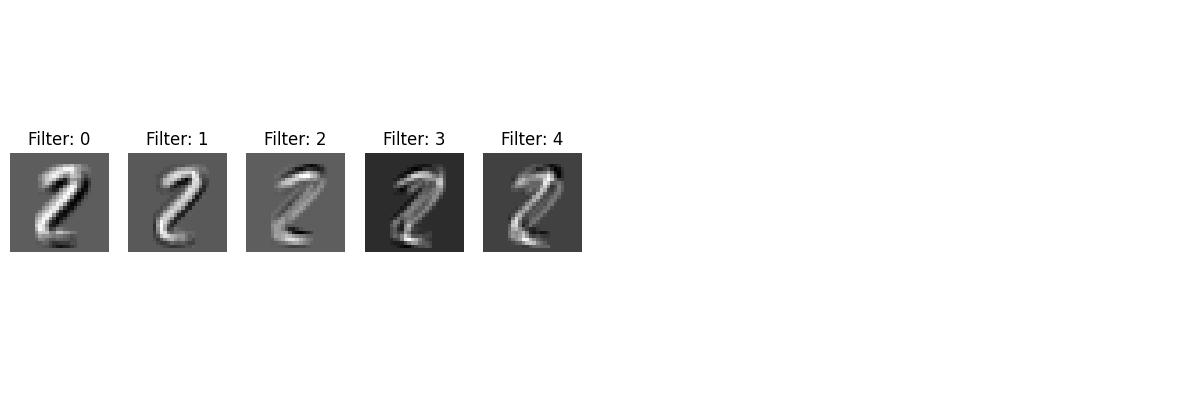

In [35]:
fv._set_submodel(layer_name="conv1")
fig, axes = fv(img, verbose=True)

Label: 8 (Prob: 98.5018%)
Label: 2 (Prob: 0.9573%)
Label: 5 (Prob: 0.3176%)
Label: 3 (Prob: 0.1481%)
Label: 9 (Prob: 0.0504%)


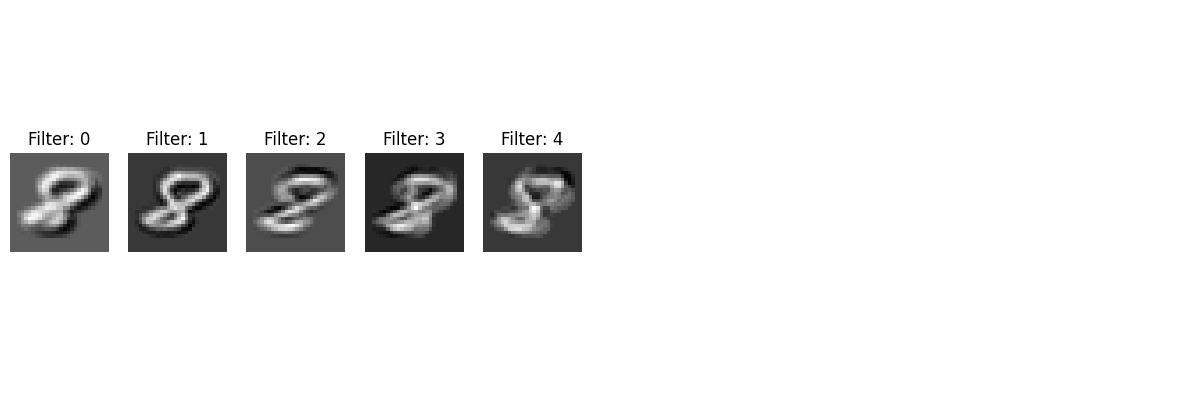

In [36]:
fig, axes = fv(false_img, verbose=True)

Label: 8 (Prob: 78.6457%)
Label: 2 (Prob: 15.0395%)
Label: 3 (Prob: 5.5634%)
Label: 9 (Prob: 0.3689%)
Label: 0 (Prob: 0.2273%)


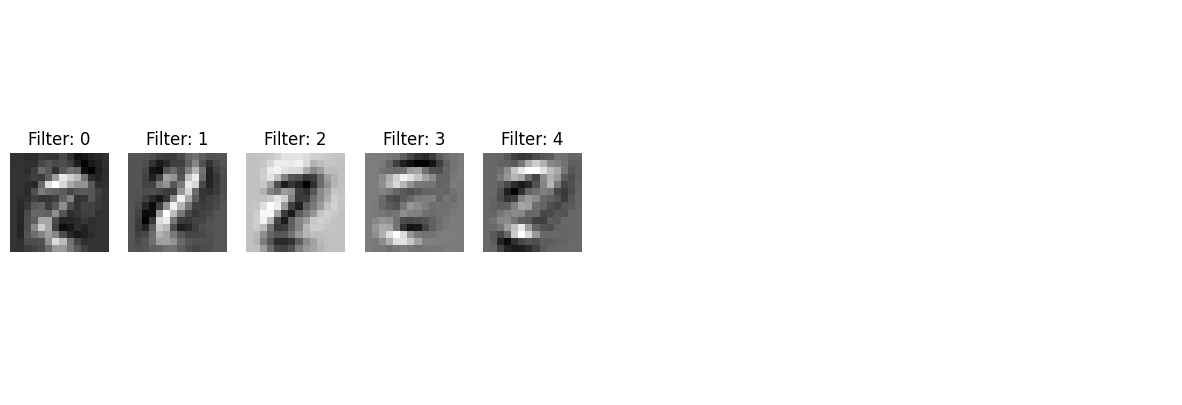

In [37]:
fv._set_submodel(layer_name="conv2")
fig, axes = fv(img, verbose=True)

Label: 8 (Prob: 98.5018%)
Label: 2 (Prob: 0.9573%)
Label: 5 (Prob: 0.3176%)
Label: 3 (Prob: 0.1481%)
Label: 9 (Prob: 0.0504%)


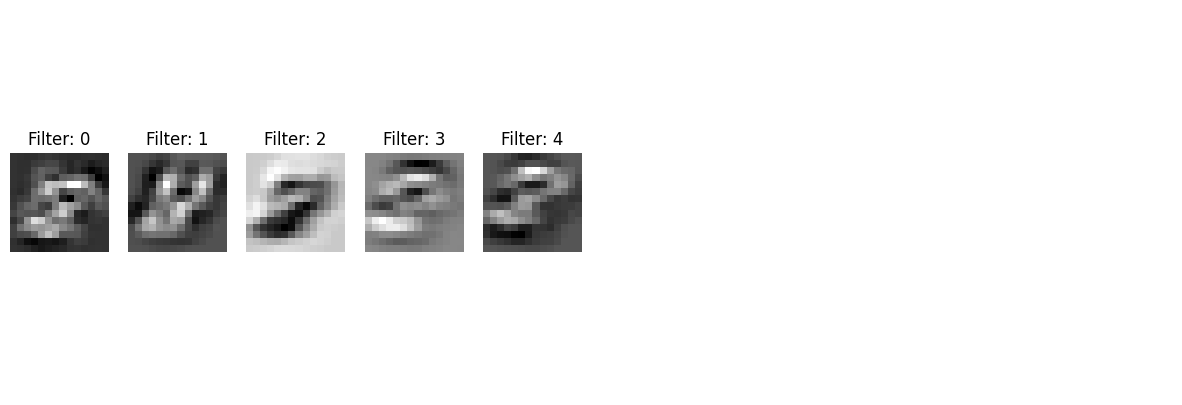

In [38]:
fig, axes = fv(false_img, verbose=True)